## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

## Step 1: Import Necessary Libraries

In [163]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Loading and Processing Data from AdBench

In [165]:

# List of datasets to use
datasets = ['2_annthyroid', '5_campaign', '39_vertebral']

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


## Step 3: Defining Function to Train CatBoost and Compute Similarity

In [167]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

def compute_similarity(X, y, active_learning_fraction=0.2, query_strategy='clusters'):
    # Split data into labeled (small) and unlabeled sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_labeled = int(active_learning_fraction * len(X_train))

    # Ensure that we have diverse labels by stratifying on y
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 1:  # Check if only one unique label exists
        raise ValueError("Training set has only one unique target value. Adjust sampling method.")

    # Create labeled and unlabeled pools
    X_labeled, X_unlabeled = X_train[:n_labeled], X_train[n_labeled:]
    y_labeled, y_unlabeled = y_train[:n_labeled], y_train[n_labeled:]

    # Train initial CatBoost Regressor on labeled data
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)

    try:
        model.fit(X_labeled, y_labeled)
    except:
        print("Re-sampling to ensure diverse labels in active learning step.")

        # Pick samples that ensure label diversity
        _, X_labeled, _, y_labeled = train_test_split(X_train, y_train, train_size=n_labeled, stratify=y_train)

        model.fit(X_labeled, y_labeled)

    # Active Learning: Query Strategy - Clusters
    if query_strategy == 'clusters':
        kmeans = KMeans(n_clusters=n_labeled, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_unlabeled)

        # Select one representative point per cluster
        selected_indices = []
        for cluster in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster)[0]
            selected_indices.append(cluster_indices[0])  # Pick first point in each cluster

        # Add selected points to labeled pool
        X_labeled = np.vstack((X_labeled, X_unlabeled[selected_indices]))
        y_labeled = np.hstack((y_labeled, y_unlabeled[selected_indices]))

    # Retrain model with expanded labeled dataset
    model.fit(X_labeled, y_labeled)

    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_labeled)

    # Compute errors for tree importance
    train_preds = model.predict(X_labeled)
    errors = np.square(train_preds - y_labeled)  # Squared error per instance

    tree_errors = [
        mean_squared_error(y_labeled, np.array(list(model.staged_predict(X_labeled, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]

    tree_errors = np.array(tree_errors)

    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)  # Ensure positive values
    delta_t /= np.sum(delta_t)  # Normalize to sum to 1

    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_labeled), len(X_labeled)))

    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_labeled)):
            for j in range(len(X_labeled)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]

    similarity_matrix /= num_trees  # Normalize similarity scores

    # Ensure all values are positive using Min-Max scaling
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)

    return similarity_matrix, model


## Step 4: Training Model and Computing Similarity for Each Dataset

In [169]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    X, y = load_dataset(dataset)
    
    # Sub-sample 1000 instances (or full dataset if smaller)
    sample_size = min(100, len(X))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity
    similarity_matrix, model = compute_similarity(X_sample, y_sample)
    results[dataset] = {'similarity_matrix': similarity_matrix, 'model': model}

Processing 2_annthyroid...
Re-sampling to ensure diverse labels in active learning step.
Processing 5_campaign...
Processing 39_vertebral...


## Step 5: Plotting Similarity Heatmaps

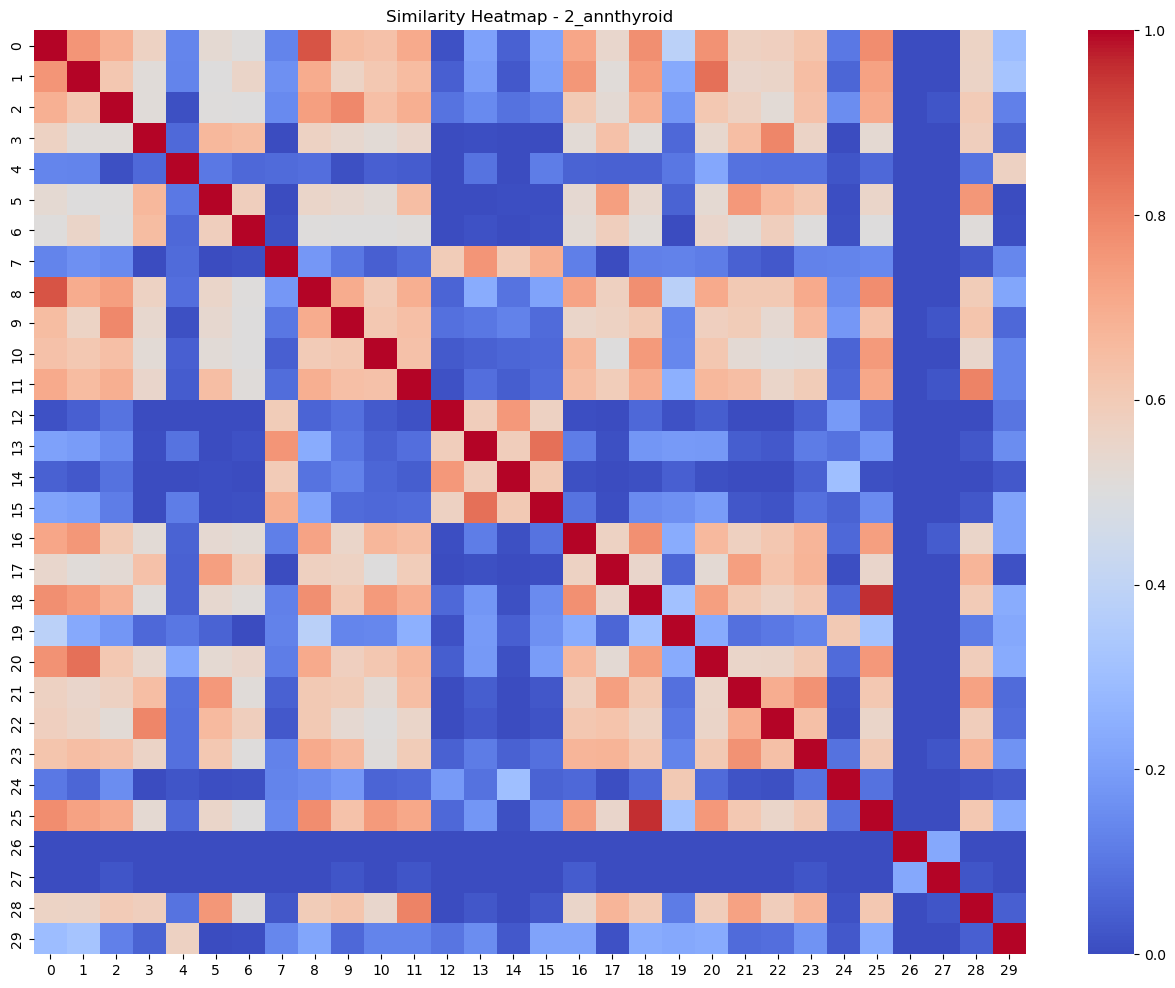

In [171]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['2_annthyroid']['similarity_matrix'], '2_annthyroid')

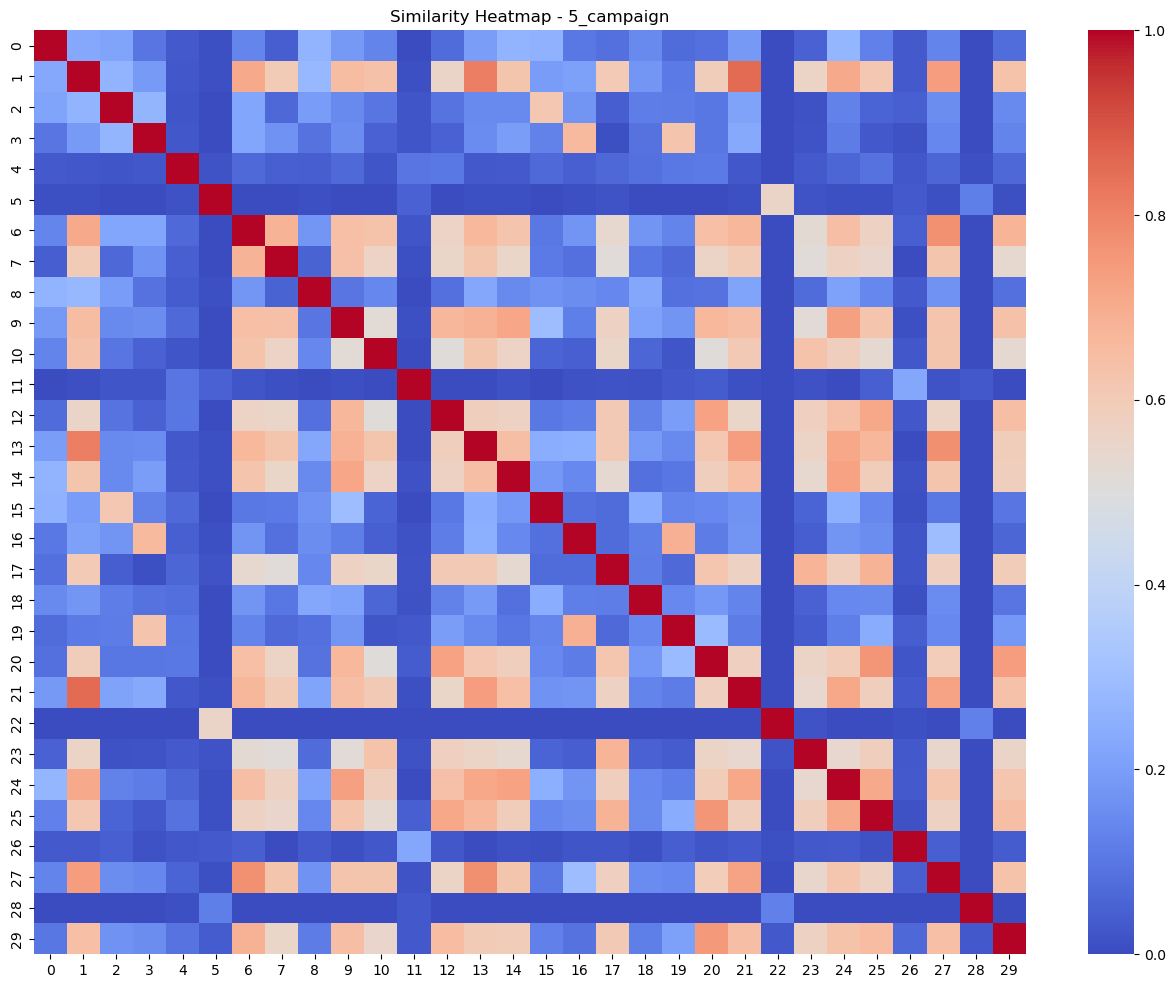

In [172]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['5_campaign']['similarity_matrix'], '5_campaign')

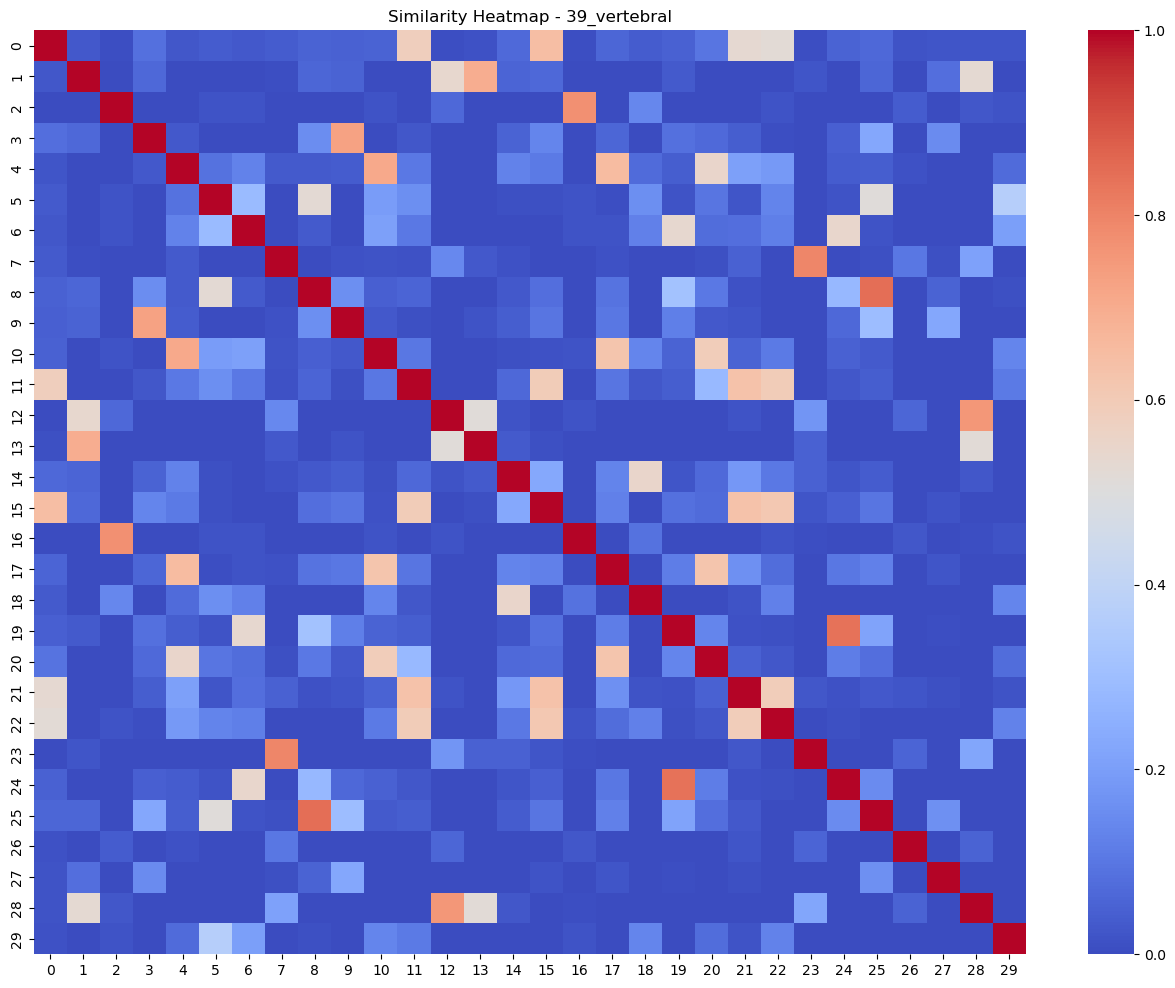

In [173]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['39_vertebral']['similarity_matrix'], '39_vertebral')

In [174]:
import pandas as pd

def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

# Example: Display similarity DataFrame for '2_annthyroid'
display_similarity_dataframe('2_annthyroid')


Similarity DataFrame for 2_annthyroid:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.761390,0.689530,0.566826,0.135337,0.527549,0.504686,0.132675,0.895742,0.648559
1,0.761390,1.000000,0.616580,0.514097,0.131030,0.500949,0.557430,0.163198,0.699924,0.564264
2,0.689530,0.616580,1.000000,0.515137,0.009912,0.506268,0.500396,0.145430,0.736410,0.790049
3,0.566826,0.514097,0.515137,1.000000,0.069665,0.664176,0.649247,0.002548,0.567817,0.542264
4,0.135337,0.131030,0.009912,0.069665,1.000000,0.103889,0.065284,0.072005,0.080796,0.010364
5,0.527549,0.500949,0.506268,0.664176,0.103889,1.000000,0.582317,0.000939,0.554686,0.536600
6,0.504686,0.557430,0.500396,0.649247,0.065284,0.582317,1.000000,0.009418,0.505677,0.502878
7,0.132675,0.163198,0.145430,0.002548,0.072005,0.000939,0.009418,1.000000,0.181532,0.100851
8,0.895742,0.699924,0.736410,0.567817,0.080796,0.554686,0.505677,0.181532,1.000000,0.700615
9,0.648559,0.564264,0.790049,0.542264,0.010364,0.536600,0.502878,0.100851,0.700615,1.000000


In [175]:
display_similarity_dataframe('5_campaign')

Similarity DataFrame for 5_campaign:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.229524,0.215436,0.097018,0.032064,0.010385,0.135051,0.039245,0.264027,0.185829
1,0.229524,1.000000,0.262551,0.189146,0.025932,0.010385,0.709472,0.598272,0.279531,0.648616
2,0.215436,0.262551,1.000000,0.267051,0.020365,0.000000,0.222200,0.066009,0.192153,0.144989
3,0.097018,0.189146,0.267051,1.000000,0.024024,0.000000,0.222601,0.171405,0.086980,0.155732
4,0.033227,0.027102,0.021542,0.025197,1.000000,0.016683,0.068116,0.044723,0.039307,0.067786
5,0.010385,0.010385,0.000000,0.000000,0.015500,1.000000,0.000000,0.000000,0.010385,0.000000
6,0.135051,0.709472,0.222200,0.222601,0.066995,0.000000,1.000000,0.680201,0.179623,0.641445
7,0.039245,0.598272,0.066009,0.171405,0.043573,0.000000,0.680201,1.000000,0.051565,0.640552
8,0.264027,0.279531,0.192153,0.086980,0.038151,0.010385,0.179623,0.051565,1.000000,0.094100
9,0.185829,0.648616,0.144989,0.155732,0.066665,0.000000,0.641445,0.640552,0.094100,1.000000


In [176]:
display_similarity_dataframe('39_vertebral')

Similarity DataFrame for 39_vertebral:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.028422,0.006963,0.085015,0.025989,0.037055,0.028614,0.035364,0.052700,0.047267
1,0.024416,1.000000,0.000000,0.064730,0.000000,0.000000,0.000000,0.004377,0.061758,0.051896
2,0.002869,0.000000,1.000000,0.000000,0.001947,0.019377,0.018570,0.001947,0.000000,0.000000
3,0.081243,0.064730,0.000000,1.000000,0.031028,0.001324,0.001324,0.000507,0.153359,0.729801
4,0.021973,0.000000,0.001947,0.031028,1.000000,0.088167,0.125994,0.033520,0.033442,0.038317
5,0.033085,0.000000,0.019377,0.001324,0.088167,1.000000,0.286194,0.001947,0.525958,0.000000
6,0.024609,0.000000,0.018570,0.001324,0.125994,0.286194,1.000000,0.001947,0.032233,0.000000
7,0.031387,0.004377,0.001947,0.000507,0.033520,0.001947,0.001947,1.000000,0.000507,0.014014
8,0.048795,0.061758,0.000000,0.153359,0.033442,0.525958,0.032233,0.000507,1.000000,0.158175
9,0.043339,0.051896,0.000000,0.729801,0.038317,0.000000,0.000000,0.014014,0.158175,1.000000


## Step 6: Save Model and Results

In [178]:
with open('proximity_learning_catboost.pkl', 'wb') as f:
    pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
